In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import deluca
import gym
import jax
import jax.numpy as jnp
from deluca.envs import LDS
from deluca.agents import GPC
from tqdm import tqdm

W0324 12:38:08.138043 4440296960 xla_bridge.py:131] No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/Users/alexjyu/miniconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import time 

def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    # plt.title("%s | Step: %d %s" % (env._spec.id,step, info))
    plt.title("%s | Step: %d %s" % (type(env).__name__,step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    # time.sleep(0.1)
    display.display(plt.gcf())

def smooth_show_state(env, step=0, prev_state=None, info=""):
    new_state = env.state
    dist = ((new_state[1] - prev_state[1])**2 + (new_state[0] - prev_state[0])**2) ** 0.5
    num_steps = max(1, int(dist/0.1)) # enforce num_steps >= 1
    for i in range(1, num_steps + 1):
        intermediate_state = prev_state * float(1 - i/(num_steps)) + new_state * float(i/(num_steps))
        env.state = intermediate_state
        plt.figure(3)
        plt.clf()
        plt.imshow(env.render(mode='rgb_array'))
        # plt.title("%s | Step: %d %s" % (env._spec.id,step, info))
        plt.title("%s | Step: %d %s" % (type(env).__name__,step, info))
        plt.axis('off')

        display.clear_output(wait=True)
        display.display(plt.gcf())
    # time.sleep(10.0)
    
def loop(context, i):
    env, controller = context
    A, B, state = env.A, env.B, env.state
    try:
        action = controller(state, A, B)
    except:
        action = controller(state)
    prev_state = env.state
    env.step(action)
    smooth_show_state(env, step=i, prev_state=prev_state)
    # state = A @ state + B @ action + np.random.normal(0, 0.2, size=(n,1)) # gaussian noise

    # if(i % T//2 == 0): # switch system
    #     A,B = jnp.array([[1.,1.5], [0,1.]]), jnp.array([[0],[0.9]])
    error = jnp.linalg.norm(state)+jnp.linalg.norm(action)
    return (env, controller), error

def get_errs(T, controller, A, B):
    # state = jnp.zeros((n, 1))
    env = LDS(state_size=3, action_size=1, A=A, B=B)
    errs = [0.0]
    
    for i in tqdm(range(1, T)):
        (env, controller), error = loop((env, controller), i)
        errs.append(float(error))
    
    return errs

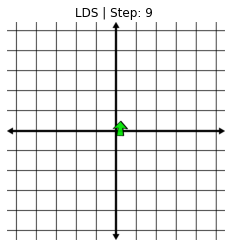

100%|██████████| 9/9 [00:13<00:00,  1.55s/it]


GPC incurs  0.5686552216259531  loss under gaussian iid noise


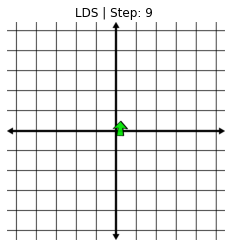

In [4]:
# for loop version
T = 10
A,B = jnp.array([[1.,.5,1.], [0,1.,0.], [0.,0.1,0.]]), jnp.array([[0],[1.2],[0.]])
gpc = GPC(A, B)
gpc_errs = get_errs(T, gpc, A, B)
# print(gpc_errs)
print("GPC incurs ", jnp.mean(jnp.asarray(gpc_errs)), " loss under gaussian iid noise")